In [23]:
# LSTM using closing prices


In [24]:
# import necesitites
import numpy as np
import pandas as pd
import hvplot.pandas

In [25]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice 
# to comment this out and run multiple experiments to evaluate your 
# model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [26]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv('btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [27]:
# Load the historical closing prices for bitcoin
df2 = pd.read_csv('btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [28]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [29]:
# print head
df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


In [30]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [31]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Try a window size anywhere from 1 to 10 and see how the model performance changes
window_size = 1

# Column index 1 is the `Close` column
feature_column = 1
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)
print(f"X sample values:\n{X[:5]} \n")
print(f"y sample values:\n{y[:5]}")

X sample values:
[[9114.719727]
 [8870.820313]
 [9251.269531]
 [8218.049805]
 [6937.080078]] 

y sample values:
[[8870.820313]
 [9251.269531]
 [8218.049805]
 [6937.080078]
 [7701.25    ]]


In [32]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[:split-1]
X_test = X[split:]
y_train = y[:split-1]
y_test = y[split:]


In [33]:
# Use MinMaxScaler to scale the data between 0 and 1. 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [34]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print(f"X_train sample values:\n{X_train[:5]} \n")
print(f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.60761794]]

 [[0.58242373]]

 [[0.62172321]]

 [[0.51499412]]

 [[0.38267307]]] 

X_test sample values:
[[[0.03974167]]

 [[0.04528668]]

 [[0.04528668]]

 [[0.07024855]]

 [[0.07145402]]]


In [35]:
# build and train lstm rnn

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [37]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 

model = Sequential()

number_units = 30
dropout_fraction = 0.2

# layer 1
model.add(LSTM(units = number_units,
               return_sequences = True,
               input_shape=(X_train.shape[1], 1))
         )

model.add(Dropout(dropout_fraction))

# layer 2
model.add(LSTM(units = number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# output layer
model.add(Dense(1))


In [38]:
# Compile the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [39]:
# Summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 30)             3840      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 30)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 30)             7320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 30)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [40]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended

model.fit(X_train, y_train, epochs = 10, shuffle = False, batch_size = 1, verbose = 1)


Train on 377 samples
Epoch 1/10
377/377 [==============================] - 6s 16ms/sample - loss: 0.0524
Epoch 2/10
377/377 [==============================] - 1s 3ms/sample - loss: 0.0253
Epoch 3/10
377/377 [==============================] - 1s 3ms/sample - loss: 0.0179
Epoch 4/10
377/377 [==============================] - 1s 3ms/sample - loss: 0.0116
Epoch 5/10
377/377 [==============================] - 1s 3ms/sample - loss: 0.0085
Epoch 6/10
377/377 [==============================] - 1s 3ms/sample - loss: 0.0059
Epoch 7/10
377/377 [==============================] - 1s 3ms/sample - loss: 0.0042
Epoch 8/10
377/377 [==============================] - 1s 3ms/sample - loss: 0.0041
Epoch 9/10
377/377 [==============================] - 1s 3ms/sample - loss: 0.0040
Epoch 10/10
377/377 [==============================] - 1s 3ms/sample - loss: 0.0042


In [41]:
# Evaluate the model

model.evaluate(X_test, y_test)

163/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.027883088536149153

In [45]:
# Make some predictions

predicted = model.predict(X_test)

In [46]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [47]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
})
stocks.head()

,Real,Predicted
0,3670.919922,3625.541992
1,3670.919922,3663.253174
2,3912.570068,3663.253174
3,3924.239990,3833.080322
4,3974.050049,3841.282715


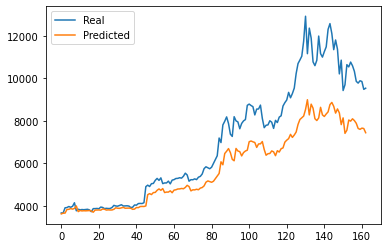

In [48]:
# Plot the real vs predicted values as a line chart

stocks.plot()